# import data

In [1]:
#import necessary libraries
import xarray as xr
from netCDF4 import Dataset, MFDataset, num2date
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import os
import cartopy.feature as cfeature
import pandas as pd
import seaborn as sns
from pyproj import Proj


In [10]:
#counties shapefile
import cartopy.io.shapereader as shpreader
dirr = r"/home/ksz4578/Heat_Pump_Project/SMOKE_sensitivity_analyses/"
reader = shpreader.Reader(dirr + 'counties/countyl010g.shp')
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

In [11]:
population_df = pd.read_csv(dirr + 'USA_100_NOFILL.txt', delimiter='\t', header=None, skiprows=25)

In [12]:
detached_housing_df = pd.read_csv(dirr + 'USA_135_NOFILL.txt', delimiter='\t', header=None, skiprows=16)

In [13]:
unit_housing_df = pd.read_csv(dirr + 'USA_136_NOFILL.txt', delimiter='\t', header=None, skiprows=16)

In [14]:
NLCD_low_intensity_df = pd.read_csv(dirr + 'USA_300_NOFILL.txt', delimiter='\t', header=None, skiprows=2)

## Convert to numpy 2D arrays

In [15]:
def pandas_to_ndarray(df, num_rows, num_cols, data = 6, row_col = 2, col_col = 3):

    # Create an empty numpy array
    numpy_array = np.zeros((num_rows, num_cols), dtype=df[data].dtype)

    # Populate the numpy array with values from the DataFrame
    for index, row in df.iterrows():
        numpy_array[row[col_col]-1, row[row_col]-1] = row[data]

    return numpy_array



In [16]:
population_ndarray = pandas_to_ndarray(population_df, num_rows = 1008, num_cols = 1332)
detached_housing_ndarray = pandas_to_ndarray(detached_housing_df, num_rows = 1332, num_cols = 1548)
unit_housing_ndarray = pandas_to_ndarray(unit_housing_df, num_rows = 1332, num_cols = 1548)
NLCD_low_intensity_ndarray = pandas_to_ndarray(NLCD_low_intensity_df, num_rows = 1008, num_cols = 1332)

In [17]:
population_ndarray_surg = pandas_to_ndarray(population_df, num_rows = 1008, num_cols = 1332, data = 4)
NLCD_low_intensity_ndarray_surg = pandas_to_ndarray(NLCD_low_intensity_df, num_rows = 1008, num_cols = 1332, data = 4)
detached_housing_ndarray_surg = pandas_to_ndarray(detached_housing_df, num_rows = 1332, num_cols = 1548, data = 4)
unit_housing_ndarray_surg = pandas_to_ndarray(unit_housing_df, num_rows = 1332, num_cols = 1548, data = 4)

## MAP LAT LON

In [18]:
# Define the Lambert Conformal Conic projection parameters
def map_lat_lon(proj_params, xorig, yorig, ncols, nrows):
    # Define the projection transformation
    lcc_proj = Proj(proj_params)

    # Define the grid indices
    xcell, ycell = 4000, 4000  # Size of grid cells
    
    # Generate grid points
    x = np.arange(xorig, xorig + xcell * ncols, xcell)
    y = np.arange(yorig, yorig + ycell * nrows, ycell)
    
    # Create a meshgrid from the grid points
    x_mesh, y_mesh = np.meshgrid(x, y)
    
    # Convert grid indices to latitude and longitude using the projection
    lon_4km, lat_4km = lcc_proj(x_mesh, y_mesh, inverse=True)

    # Print latitude and longitude for a sample point
    print("Latitude at index (0, 0):", lat_4km[1, 1])
    print("Longitude at index (0, 0):", lon_4km[0, 1])
    
    return lon_4km, lat_4km

lon_2016, lat_2016 = map_lat_lon(
    proj_params = {'proj': 'lcc',
                   'lat_1': 33,
                   'lat_2': 45,
                   'lon_0': -97,
                   'lat_0': 40},
    xorig = -2736000, yorig= -2088000,  # Coordinates of the origin
    ncols = 1332, nrows = 1008  # Number of columns and rows
    )

lon_2020, lat_2020 = map_lat_lon(
    proj_params = {'proj': 'lcc',
                   'lat_1': 33,
                   'lat_2': 45,
                   'lon_0': -97,
                   'lat_0': 40},
    xorig = -2952000, yorig = -2772000,  # Coordinates of the origin
    ncols = 1548, nrows = 1332  # Number of columns and rows
    )

Latitude at index (0, 0): 18.153789785490076
Longitude at index (0, 0): -121.69014701763984
Latitude at index (0, 0): 12.1480055982206
Longitude at index (0, 0): -121.89458014713186


# Plotting

In [19]:
#Challenge #2 change projection type and 
def plot(data, vs, label, title, lat, lon, counties = False, bounds = False, difference = False):
    if not bounds:
        bounds = [[0, lat.shape[0]], [0, lon.shape[1]]]
    
    #create matplotlib figure
    plt.figure(figsize=(8,5))

    #create subplot with the an Mollweide projection
    ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=-97.0, globe=None))

    #create map with 
    if difference:
            mm = ax.pcolormesh(lon[ bounds[0][0]:bounds[0][1], bounds[1][0]:bounds[1][1] ],
                       lat[ bounds[0][0]:bounds[0][1], bounds[1][0]:bounds[1][1] ],
                       data,
                       transform=ccrs.PlateCarree(),
                       cmap = "RdBu" #use inferno colormap
                      )
    else:
            mm = ax.pcolormesh(lon[ bounds[0][0]:bounds[0][1], bounds[1][0]:bounds[1][1] ],
                       lat[ bounds[0][0]:bounds[0][1], bounds[1][0]:bounds[1][1] ],
                       data[ bounds[0][0]:bounds[0][1], bounds[1][0]:bounds[1][1] ],
                       transform=ccrs.PlateCarree(),
                       cmap = "viridis" #use inferno colormap
                      )
    
    #map coastlines on the map with resolution 100m
    ax.coastlines(resolution='110m')

    #generate features
    resol = '10m'  # use data at this scale
    bodr = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale=resol, facecolor='none', alpha=0.7)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', scale=resol, edgecolor='none', facecolor=cfeature.COLORS['water'])
    lakes = cfeature.NaturalEarthFeature('physical', 'lakes', scale=resol, edgecolor='b', facecolor=cfeature.COLORS['water'])
    rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', scale=resol, edgecolor='b', facecolor='none')
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m',facecolor='none')

    #add features
    ax.add_feature(states_provinces, edgecolor='white', linewidth=0.5)
    ax.add_feature(ocean, linewidth=0.2 )

    ax.add_feature(lakes, linewidth = 0)
    ax.add_feature(rivers, linewidth=0.5)
    ax.add_feature(bodr, linestyle='--', edgecolor='k', alpha=1)
    
    if counties:
        ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')

    
    #ax.stock_img(); #land images

    mm.set_clim(vmin=vs[0], vmax=vs[1])

    #plot colorbar legend
    cbar = plt.colorbar(mm)
    cbar.ax.set_ylabel(label,rotation = 90)

    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

## Get 10008 x 1332 versions

In [20]:
# these are the number of rows and columns at the start of the dataframe 
# that aren't included in 1008 x1332, based on projection info
rows_to_ignore_start = int((2952000 - 2736000)/4000)
cols_to_ignore_start = int((2772000 - 2088000)/4000)

In [21]:
# create new ROW and COL columns
def to_smaller(df):
    df['ROW'] = df[2] - rows_to_ignore_start
    df['COL'] = df[3] - cols_to_ignore_start
    
    # get the rows of pandas dataframe that are within the 1008 x 1332 grid
    df_smaller = df.loc[(df['ROW']< 1332)
                  & (df['ROW']>= 0)
                  & (df['COL']< 1008)
                  & (df['COL']>= 0)]
    return df_smaller

In [22]:
unit_housing_smaller = to_smaller(unit_housing_df)
detached_smaller = to_smaller(detached_housing_df)

In [23]:
# double check by plotting as ndarray
unit_housing_smaller_ndarray = pandas_to_ndarray(unit_housing_smaller, num_rows = 1008, num_cols = 1332, row_col = "ROW", col_col = "COL")

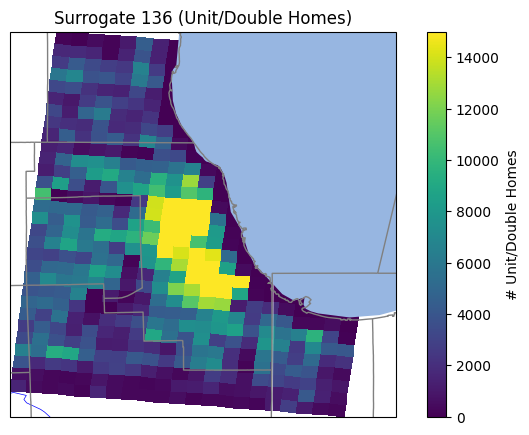

In [24]:
# confirming the remapping was successful
plot(data = unit_housing_smaller_ndarray,
     vs = [0,15000],
     label = "# Unit/Double Homes", 
     title = "Surrogate 136 (Unit/Double Homes)",
     lon = lon_2016,
     lat = lat_2016,
     counties = True,
     bounds = [[570,600],[865,886]]
    )

In [25]:
# save the dataframe as .txt file
unit_housing_smaller[2] = unit_housing_smaller['ROW']
unit_housing_smaller[3] = unit_housing_smaller['COL']
unit_housing_smaller = unit_housing_smaller.drop(['COL','ROW'], axis=1)

unit_housing_smaller.to_csv('data.txt', sep='\t', index=False)

/tmp/ipykernel_244209/3423329574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit_housing_smaller[2] = unit_housing_smaller['ROW']
/tmp/ipykernel_244209/3423329574.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit_housing_smaller[3] = unit_housing_smaller['COL']


In [26]:
detached_smaller[2] = detached_smaller['ROW']
detached_smaller[3] = detached_smaller['COL']
detached_smaller = detached_smaller.drop(['COL','ROW'], axis=1)

detached_smaller.to_csv('detached_smaller.txt', sep='\t', index=False)

/tmp/ipykernel_244209/4187283669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detached_smaller[2] = detached_smaller['ROW']
/tmp/ipykernel_244209/4187283669.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detached_smaller[3] = detached_smaller['COL']


## Plotting CONUS Surrogate Profiles

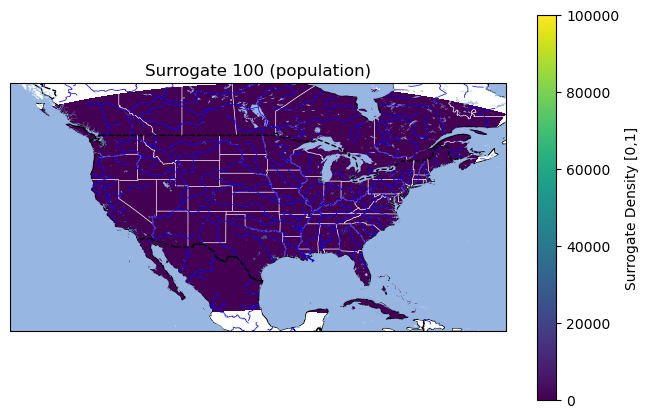

In [19]:
plot(data = population_ndarray,
     vs = [0,100000],
     label = "Surrogate Density [0,1]", 
     title = "Surrogate 100 (population)",
     lon = lon_2016,
     lat = lat_2016
    )

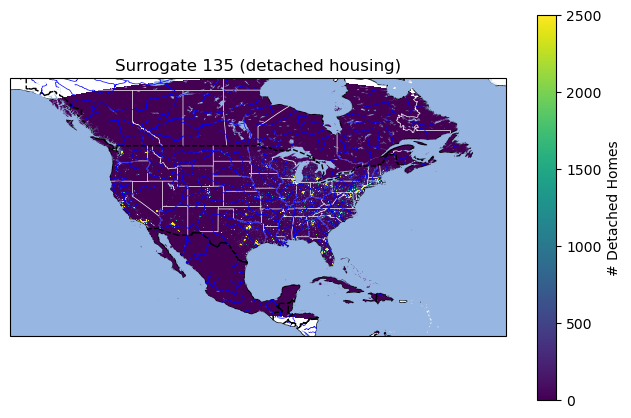

In [20]:
#detached_housing_ndarray.mean()

plot(data = detached_housing_ndarray,
     vs = [0,2500],
     label = "# Detached Homes", 
     title = "Surrogate 135 (detached housing)",
     lon = lon_2020,
     lat = lat_2020
    )

In [49]:
!(unzip counties/tl_2024_us_county.zip)

Archive:  counties/tl_2024_us_county.zip
 extracting: tl_2024_us_county.cpg   
  inflating: tl_2024_us_county.dbf   
  inflating: tl_2024_us_county.prj   
  inflating: tl_2024_us_county.shp   
  inflating: tl_2024_us_county.shp.ea.iso.xml  
  inflating: tl_2024_us_county.shp.iso.xml  
  inflating: tl_2024_us_county.shx   


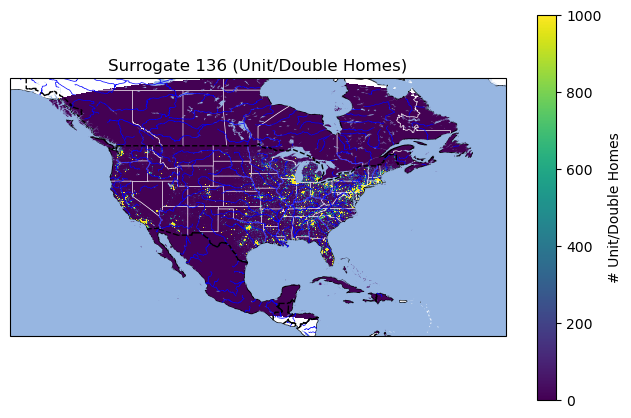

In [21]:
#detached_housing_ndarray.mean()

plot(data = unit_housing_ndarray,
     vs = [0,1000],
     label = "# Unit/Double Homes", 
     title = "Surrogate 136 (Unit/Double Homes)",
     lon = lon_2020,
     lat = lat_2020
    )

In [22]:
NLCD_low_intensity_ndarray.max()

14312711.9258969

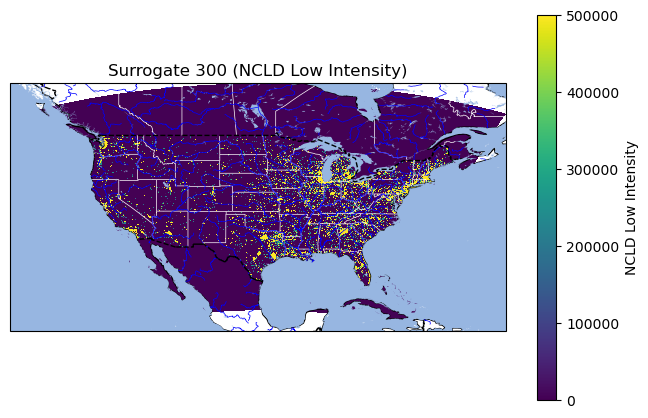

In [23]:
plot(data = NLCD_low_intensity_ndarray,
     vs = [0,500000],
     label = "NCLD Low Intensity", 
     title = "Surrogate 300 (NCLD Low Intensity)",
     lon = lon_2016,
     lat = lat_2016
    )

## Chicago Case Study

In [27]:
def plot_all(coords = [[570,600],[865,886]]):  
    plot(data = NLCD_low_intensity_ndarray_surg,
         vs = [0,0.05],
         label = "NCLD Low Intensity", 
         title = "Surrogate 300 (NCLD Low Intensity)",
         lon = lon_2016,
         lat = lat_2016,
         counties = True,
         bounds = coords 
        )
    
    plot(data = unit_housing_ndarray_surg,
         vs = [0,0.05],
         label = "Single and Dual Unit Housing", 
         title = "Surrogate 136 (Single and Dual Unit Housing)",
         lon = lon_2020,
         lat = lat_2020,
         counties = True,
         bounds = [[coords[0][0]+171, coords[0][1]+171], [coords[1][0]+54, coords[1][1]+54]]
        )
         
    plot(data = detached_housing_ndarray_surg,
         vs = [0,0.05],
         label = "Detached Housing", 
         title = "Surrogate 135 (Detached Housing)",
         lon = lon_2020,
         lat = lat_2020,
         counties = True,
         bounds =  [[coords[0][0]+171, coords[0][1]+171], [coords[1][0]+54, coords[1][1]+54]]
    )
         
    plot(data = population_ndarray_surg,
         vs = [0,0.05],
         label = "Population", 
         title = "Surrogate 100 (Population)",
         lon = lon_2016,
         lat = lat_2016,
         counties = True,
         bounds = coords
    )  

In [ ]:
#Challenge #2 change projection type and 
def plot(data, vs, label, title, lat, lon, counties = False, bounds = False, difference = False):
    if not bounds:
        bounds = [[0, lat.shape[0]], [0, lon.shape[1]]]
    
    #create matplotlib figure
    plt.figure(figsize=(8,5))

    #create subplot with the an Mollweide projection
    ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=-97.0, globe=None))

    #create map with 
    if difference:
            mm = ax.pcolormesh(lon[ bounds[0][0]:bounds[0][1], bounds[1][0]:bounds[1][1] ],
                       lat[ bounds[0][0]:bounds[0][1], bounds[1][0]:bounds[1][1] ],
                       data,
                       transform=ccrs.PlateCarree(),
                       cmap = "RdBu" #use inferno colormap
                      )
    else:
            mm = ax.pcolormesh(lon[ bounds[0][0]:bounds[0][1], bounds[1][0]:bounds[1][1] ],
                       lat[ bounds[0][0]:bounds[0][1], bounds[1][0]:bounds[1][1] ],
                       data[ bounds[0][0]:bounds[0][1], bounds[1][0]:bounds[1][1] ],
                       transform=ccrs.PlateCarree(),
                       cmap = "viridis" #use inferno colormap
                      )
    
    #map coastlines on the map with resolution 100m
    ax.coastlines(resolution='110m')

    #generate features
    resol = '10m'  # use data at this scale
    bodr = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale=resol, facecolor='none', alpha=0.7)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', scale=resol, edgecolor='none', facecolor=cfeature.COLORS['water'])
    lakes = cfeature.NaturalEarthFeature('physical', 'lakes', scale=resol, edgecolor='b', facecolor=cfeature.COLORS['water'])
    rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', scale=resol, edgecolor='b', facecolor='none')
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m',facecolor='none')

    #add features
    ax.add_feature(states_provinces, edgecolor='white', linewidth=0.5)
    ax.add_feature(ocean, linewidth=0.2 )
    ax.add_feature(lakes, linewidth = 0)
    ax.add_feature(rivers, linewidth=0.5)
    ax.add_feature(bodr, linestyle='--', edgecolor='k', alpha=1)
    
    if counties:
        ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')

    
    #ax.stock_img(); #land images

    mm.set_clim(vmin=vs[0], vmax=vs[1])

    #plot colorbar legend
    cbar = plt.colorbar(mm)
    cbar.ax.set_ylabel(label,rotation = 90)

    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

In [50]:
import geopandas as gpd
counties_gdf = gpd.read_file(dirr + '/counties/tl_2024_us_county.shp')

In [129]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon

def plot_gdf_in_county(data, bounds, lat_2016, lon_2016, counties_gdf, county_name, statefp, vs, label, title):
    """
    Plot a GeoDataFrame clipped to a specific county.

    Parameters:
    - data: 2D numpy array of grid data
    - bounds: List of row/column indices for slicing the lat/lon data
    - lat_2016, lon_2016: Latitude and Longitude arrays
    - counties_gdf: GeoDataFrame of county geometries
    - county_name: Name of the county to filter by
    - statefp: State FIPS code of the county
    - vs: [vmin, vmax] for color scale
    - label: Label for the colorbar
    - title: Title for the plot
    """
    lats = lat_2016[ bounds[0][0]:bounds[0][1], bounds[1][0]:bounds[1][1] ]
    lons = lon_2016[ bounds[0][0]:bounds[0][1], bounds[1][0]:bounds[1][1] ]
    
    # Initialize an empty list for polygons and data
    polygons = []
    values = []
    
    # Iterate over the grid cells
    for i in range(lats.shape[0] - 1):  # Iterate rows
        for j in range(lons.shape[1] - 1):  # Iterate columns
            # Get the corner coordinates of the grid cell
            cell_corners = [
                (lons[i, j], lats[i, j]),         # Top-left
                (lons[i, j + 1], lats[i, j + 1]), # Top-right
                (lons[i + 1, j + 1], lats[i + 1, j + 1]), # Bottom-right
                (lons[i + 1, j], lats[i + 1, j]), # Bottom-left
            ]
            # Create a polygon from the corners
            polygons.append(Polygon(cell_corners))
            # Append the data value for the cell
            values.append(data[i, j])
    
    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(
        {'data': values},
        geometry=polygons,
        crs="EPSG:4326"  # WGS84 coordinate system
    )

    # Ensure the CRS of counties_gdf matches that of the grid (EPSG:4326)
    counties_gdf = counties_gdf.to_crs("EPSG:4326")

    # Extract the county geometry
    county_geom = counties_gdf.loc[
        (counties_gdf['NAME'] == county_name) & (counties_gdf['STATEFP'] == statefp),
        'geometry'
    ].values[0]

    # Filter and clip the GeoDataFrame
    gdf_filtered = gdf[gdf.intersects(county_geom)]
    gdf_clipped = gpd.clip(gdf_filtered, county_geom)

    # Plot
    plt.figure(figsize=(8, 6))
    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    gdf_clipped.plot(
        column='data', cmap='RdBu', legend=False, ax=ax, transform=ccrs.PlateCarree(),
        vmin=vs[0], vmax=vs[1]  # Set min and max values for the colormap
    )
    # Add county boundary
    #ax.add_geometries(
    #    [county_geom], crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=0.7
    #)

    # Add map features
    ax.coastlines(resolution='10m')
    #ax.add_feature(cfeature.BORDERS, linestyle='--', alpha=0.5)
    #ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
    lakes = cfeature.NaturalEarthFeature('physical', 'lakes', scale='10m', edgecolor='b', facecolor=cfeature.COLORS['water'])
    ax.add_feature(lakes, linewidth = 0)

    # Set color scale and labels
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    import matplotlib.colors as mcolors
    norm = mcolors.Normalize(vmin=vs[0], vmax=vs[1])

    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='RdBu', norm=norm), ax=ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16)  # Set the tick label size
    plt.show()
    return ax


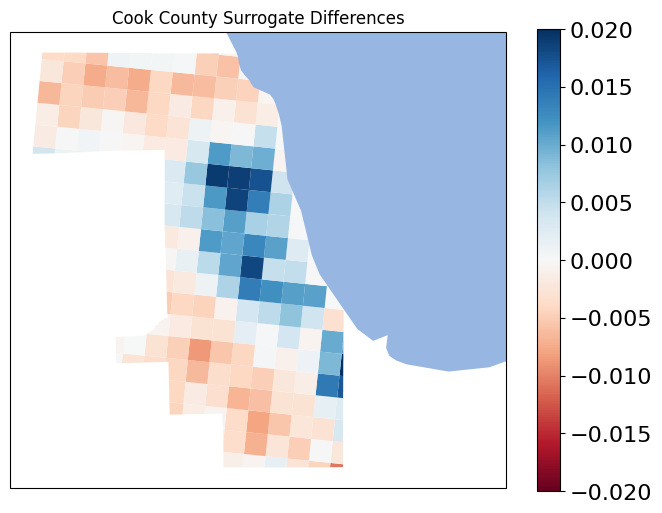

In [131]:
coords = [[570,600],[865,886]]
data1 = unit_housing_ndarray_surg[coords[0][0]+171: coords[0][1]+171, coords[1][0]+54: coords[1][1]+54]
data2 = NLCD_low_intensity_ndarray_surg[coords[0][0]:coords[0][1], coords[1][0]:coords[1][1]]
data = data1 - data2


ax  = plot_gdf_in_county(data = data, 
                   bounds = coords, 
                   lat_2016 = lat_2016, 
                   lon_2016 = lon_2016, 
                   counties_gdf = counties_gdf, 
                   county_name = "Cook", 
                   statefp = "17", 
                    vs=[-0.02, 0.02],
                    label="Surrogate Weighting Difference",
                    title="Cook County Surrogate Differences")


In [117]:
ax.get_legend()

In [118]:
lats.shape[0]

30

In [28]:
def plot_diff(coords = [[570,600],[865,886]]):
    data1 = unit_housing_ndarray_surg[coords[0][0]+171: coords[0][1]+171, coords[1][0]+54: coords[1][1]+54]
    data2 = NLCD_low_intensity_ndarray_surg[coords[0][0]:coords[0][1], coords[1][0]:coords[1][1]]
    data = data1 - data2
    plot(data = data,
             vs = [-0.05,0.05],
             label = "Surrogate Weighting Difference", 
             title = "Difference Between 2020 (135) and 2016 (300)",
             lon = lon_2016,
             lat = lat_2016,
             counties = True,
             bounds = coords,
             difference = True)

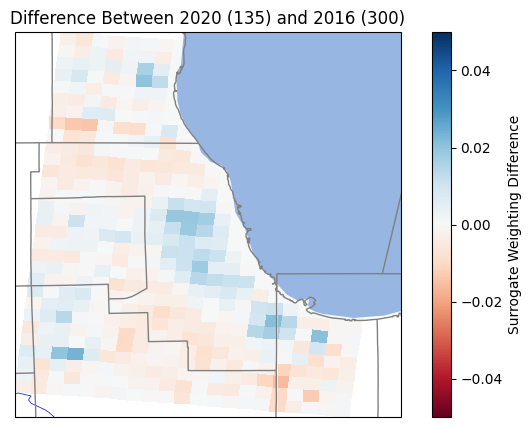

In [30]:
#plot_all()
plot_diff()

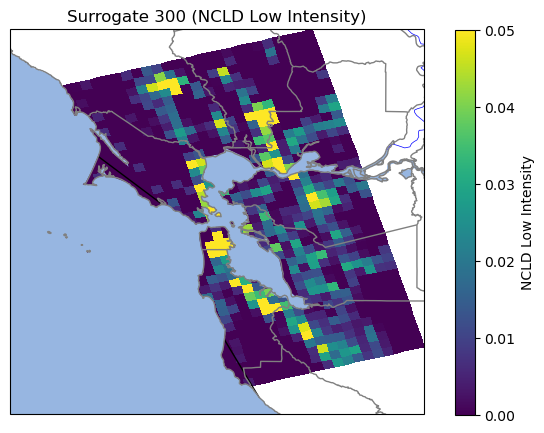

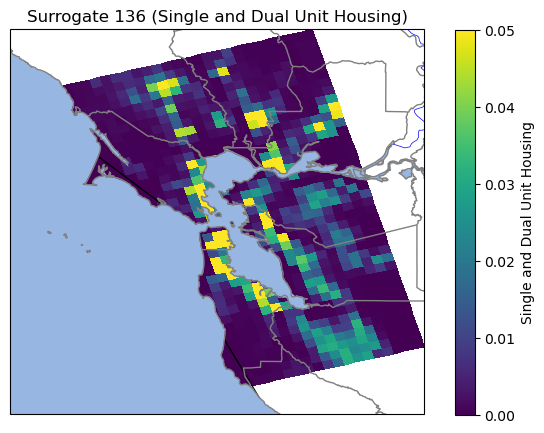

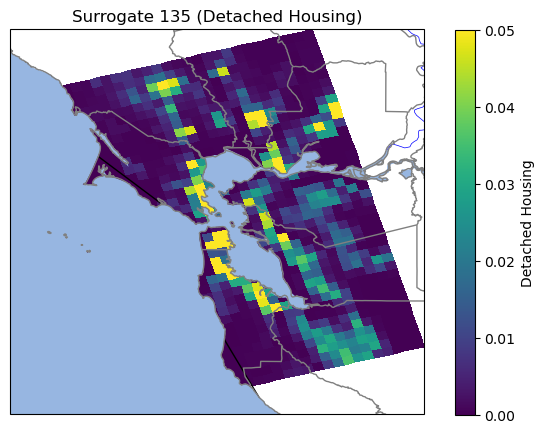

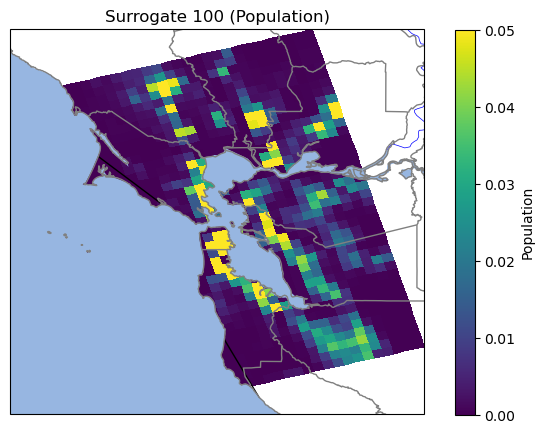

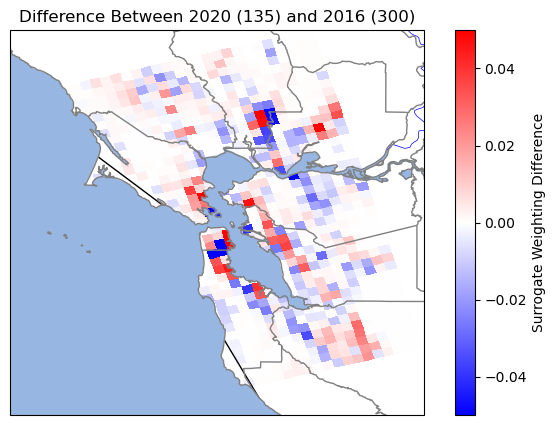

In [27]:
plot_all([[520,560],[120,150]])
plot_diff([[520,560],[120,150]])

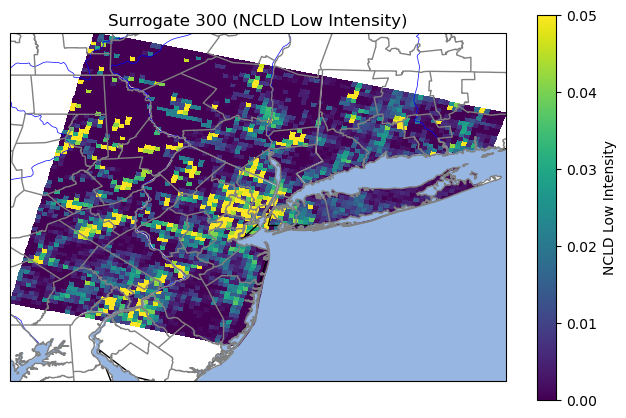

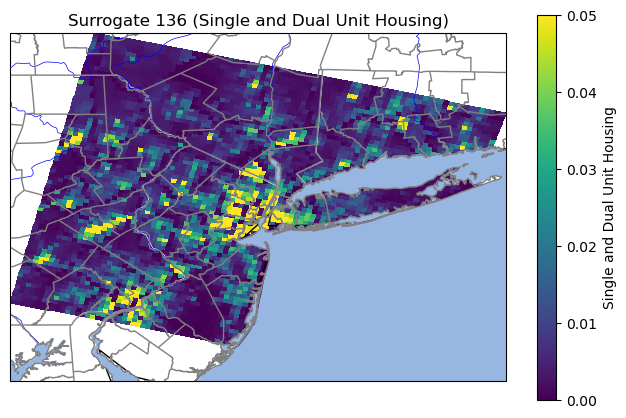

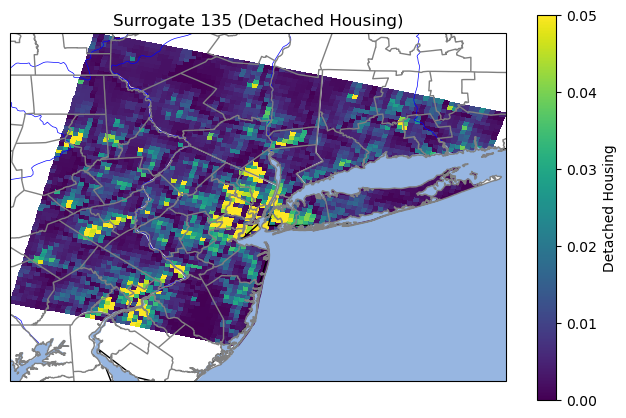

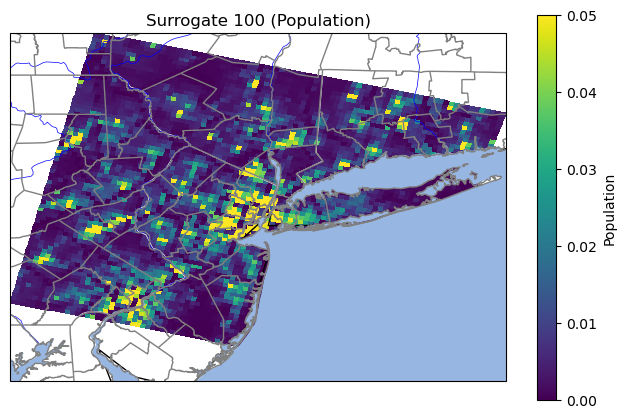

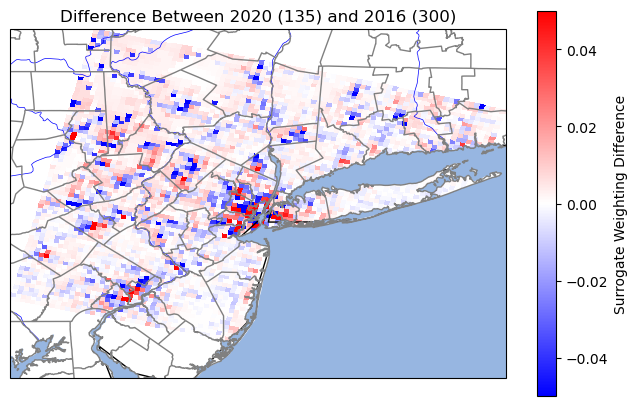

In [40]:
plot_all([[570,640], [1120,1200]])
plot_diff([[570,640], [1120,1200]])

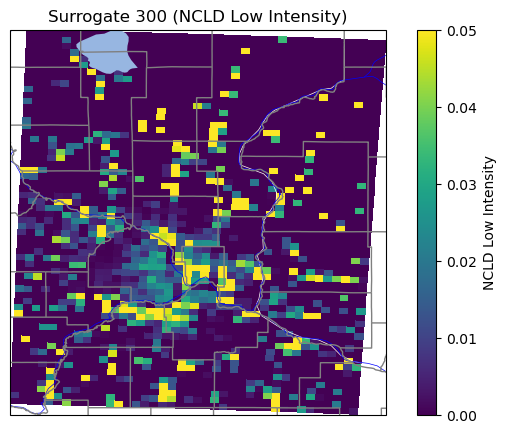

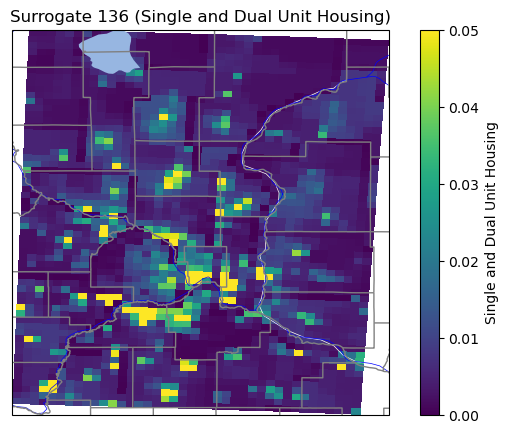

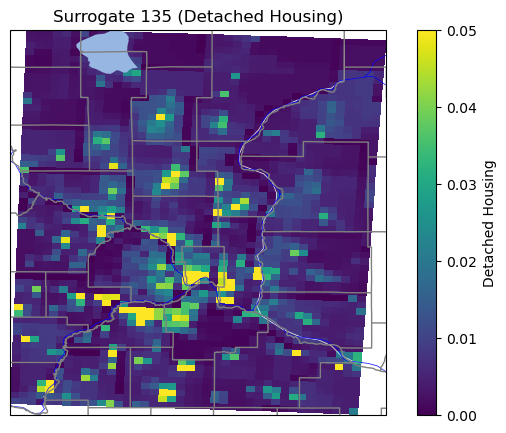

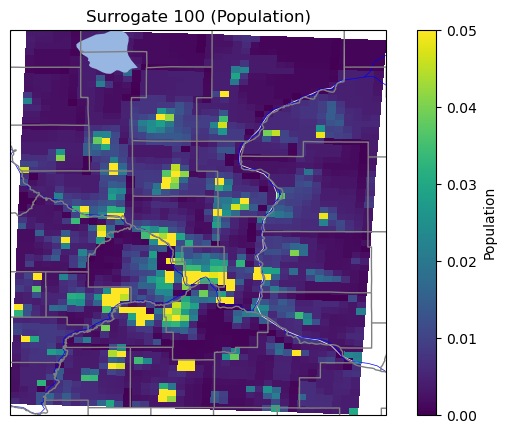

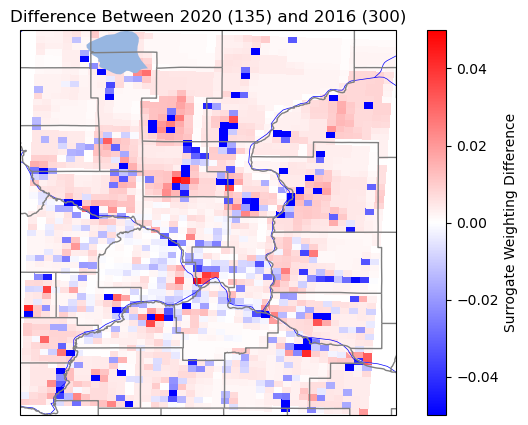

In [29]:
plot_all([[640,700],[740,780]])
plot_diff([[640,700],[740,780]])